<a href="https://colab.research.google.com/github/quinnie-nguyen/Woman_in_Data_Science_2021/blob/main/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Introduction:**

Intensive Care Units (ICUs) often lack verified medical histories for incoming patients. A patient in distress or a patient who is brought in confused or unresponsive may not be able to provide information about chronic conditions such as heart disease, injuries, or diabetes. Medical records may take days to transfer, especially for a patient from another medical provider or system.

Knowledge about chronic conditions such as diabetes can inform clinical decisions about patient care and ultimately improve patient outcomes.

This project will focus on models to determine whether a patient admitted to an ICU has been diagnosed with a particular type of diabetes, Diabetes Mellitus, using data from the first 24 hours of intensive care.

# Loading data

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [111]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline
from functools import partial
from collections import Counter
from sklearn.naive_bayes import GaussianNB
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [6]:
train = pd.read_csv('/content/gdrive/My Drive/WIDS/TrainingWiDS2021.csv')
predict = pd.read_csv('/content/gdrive/My Drive/WIDS/UnlabeledWiDS2021.csv')
train['label'] = 'train'
predict['label'] = 'predict'
dictionary = pd.read_excel('/content/gdrive/My Drive/WIDS/DataDictionaryWiDS2021-fixed-thu-tu.xlsx')

In [7]:
print(train.head())
print(train.iloc[:,-2].value_counts())

   Unnamed: 0  encounter_id  ...  diabetes_mellitus  label
0           1        214826  ...                  1  train
1           2        246060  ...                  1  train
2           3        276985  ...                  0  train
3           4        262220  ...                  0  train
4           5        201746  ...                  0  train

[5 rows x 182 columns]
0    102006
1     28151
Name: diabetes_mellitus, dtype: int64


At first glance, we are asked to build model to classify patient with diabettes mellitus or not. To the best of my knowledge, it is too many features for building a good classifier, since our model seems likly to be missleading by noises or irrelavent covariates. Hence, it is not a good idea to to include all available variables.

Secondly, it is noteworthy that the data set we have at hand is obviously imbalanced. 

In general, till now we have to problem needed to deal with:


1.   Feature selection
2.   Resampling data



In [8]:
train.drop(['encounter_id', 'hospital_id', 'Unnamed: 0', 'icu_id'], inplace=True, axis=1)
predict.drop(['encounter_id', 'hospital_id', 'Unnamed: 0', 'icu_id'], inplace=True, axis=1)

Since our teammates come from diverse background, but not with clinical or medicine prior knowledge, we decide to proceeds as follows:



1.   Seeking suggestion from experts
2.   Feature selection from data science point of view.





# Missing values

Our strategy is as follows:

*   Drop all columns with >80% missing value.
*   Drop all row with >50% the remaining features.

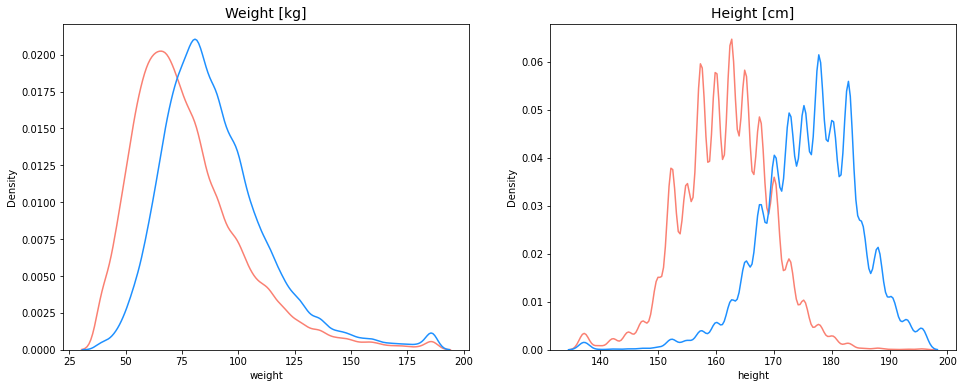

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

sns.kdeplot(train[train.gender == 'F'].weight, label='Female', color='salmon', ax=ax[0])
sns.kdeplot(train[train.gender == 'M'].weight, label='Male', color='dodgerblue', ax=ax[0])
ax[0].set_title('Weight [kg]', fontsize=14)

sns.kdeplot(train[train.gender == 'F'].height, label='Female', color='salmon', ax=ax[1])
sns.kdeplot(train[train.gender == 'M'].height, label='Male', color='dodgerblue', ax=ax[1])
ax[1].set_title('Height [cm]', fontsize=14)

plt.show()

It is easily to see from the graph that there are significant differences between weight and height of male and female. 

Keep them in mind when doing imputation for missing values.

In [10]:
print(train.groupby('gender')['height'].median())
print(train['height'].median())
print(train.groupby('gender')['weight'].median())
print(train['weight'].median())

gender
F    162.5
M    177.8
Name: height, dtype: float64
170.1
gender
F    72.5
M    85.7
Name: weight, dtype: float64
80.0


In [11]:
# impute the missing height and weight based on median group by genders
# do the same for train and test set


train["height"] = np.where((train.height.isna() & (train.gender == 'F')),
                              162.5, train["height"])
train["height"] = np.where((train.height.isna() & (train.gender == 'M')),
                              177.8, train["height"])
train["height"] = np.where((train.height.isna() & (train.gender.isna())),
                              170.1, train["height"])
train["weight"] = np.where((train.weight.isna() & (train.gender == 'F')),
                              72.5, train["weight"])
train["weight"] = np.where((train.weight.isna() & (train.gender == 'M')),
                              85.7, train["weight"])
train["weight"] = np.where((train.weight.isna() & (train.gender.isna())),
                              80, train["weight"])

predict["height"] = np.where((predict.height.isna() & (predict.gender == 'F')),
                             162.5, predict["height"])
predict["height"] = np.where((predict.height.isna() & (predict.gender == 'M')),
                             177.8, predict["height"])
predict["height"] = np.where((predict.height.isna() & (predict.gender.isna())),
                              170.1, predict["height"])
predict["weight"] = np.where((predict.weight.isna() & (predict.gender == 'F')),
                             72.5, predict["weight"])
predict["weight"] = np.where((predict.weight.isna() & (predict.gender == 'M')),
                             85.7, predict["weight"])
predict["weight"] = np.where((predict.weight.isna() & (predict.gender.isna())),
                              80, predict["weight"])

In [12]:
missing_frac = train.isnull().sum()/train.shape[0]
missing_frac = pd.DataFrame(missing_frac)
missing_frac.reset_index(inplace =True)
missing_frac.columns = ['feature', 'missing_rate']

In [13]:
# delete all col missing >80%
todelete = missing_frac[missing_frac['missing_rate'] > 0.8]['feature'].values
len(todelete)

32

In [14]:
train.drop(todelete, axis = 1, inplace =True)
predict.drop(todelete, axis = 1, inplace=True)

In [15]:
# delete all row missing >50% features
def get_row_miss_percent(df):
#    """
#    Adds a feature into the dataframe indicating the missing
#    value percentage of the corresponding row
#    """
    ncols = df.shape[1]
    f = (df.isnull().sum(axis=1) / ncols) * 100

    return f

delete_row = get_row_miss_percent(train)

In [16]:
train = train.loc[delete_row[:] < 50]

Impute missing values within binary and catergory data types

We gather train and test set to ensure that we do the same thing for them

In [17]:
train_predict = pd.concat([train, predict], axis = 0)
train_predict.reset_index(inplace=True)
train_predict = train_predict.drop(['index'], axis = 1)
categorical_cols = ['ethnicity', 'gender', 'hospital_admit_source',
                    'icu_admit_source', 'icu_stay_type', 'icu_type',
                    'label'
                    ]


binary_cols = ['elective_surgery','apache_post_operative','arf_apache',
               'intubated_apache','ventilated_apache','aids','cirrhosis',
               'gcs_unable_apache','diabetes_mellitus','hepatic_failure','readmission_status',
               'immunosuppression','leukemia','lymphoma','solid_tumor_with_metastasis']

for i, v in enumerate(binary_cols):
    train_predict[v] = train_predict[v].fillna(10)

# filling categorical columns with the most frequent value (mode)
for i, v in enumerate(categorical_cols):
    train_predict[v] = train_predict[v].fillna(train[v].value_counts().index[0])

In [18]:
class GroupImputer(BaseEstimator, TransformerMixin):
    '''
    Class used for imputing missing values in a pd.DataFrame using either mean or median of a group.
    
    Parameters
    ----------    
    group_cols : list
        List of columns used for calculating the aggregated value 
    target : str
        The name of the column to impute
    metric : str
        The metric to be used for remplacement, can be one of ['mean', 'median']
    Returns
    -------
    X : array-like
        The array with imputed values in the target column
    '''
    def __init__(self, group_cols, target, metric='mean'):
        
        assert metric in ['mean', 'median'], 'Unrecognized value for metric, should be mean/median'
        assert type(group_cols) == list, 'group_cols should be a list of columns'
        assert type(target) == str, 'target should be a string'
        
        self.group_cols = group_cols
        self.target = target
        self.metric = metric
    
    def fit(self, X, y=None):
        
        assert pd.isnull(X[self.group_cols]).any(axis=None) == False, 'There are missing values in group_cols'
        
        impute_map = X.groupby(self.group_cols)[self.target].agg(self.metric) \
                                                            .reset_index(drop=False)
        
        self.impute_map_ = impute_map
        
        return self 
    
    def transform(self, X, y=None):
        
        # make sure that the imputer was fitted
        check_is_fitted(self, 'impute_map_')
        
        X = X.copy()
        
        for index, row in self.impute_map_.iterrows():
            ind = (X[self.group_cols] == row[self.group_cols]).all(axis=1)
            X.loc[ind] = X.loc[ind].fillna(row[self.target])
        
        return X.values

In [19]:
df_imp = train_predict.copy(deep = True)

In [20]:

features = train_predict.columns
numeric_cols = [col for col in features if col not in categorical_cols and col not in binary_cols]

In [21]:
# for numeric values, we impute by using means group by ethnicity and gender
for i in range(0, len(numeric_cols)):
  imp = GroupImputer(group_cols=['ethnicity','gender'], target=numeric_cols[i],metric='mean')
  df_imp[numeric_cols[i]] = pd.DataFrame(imp.fit_transform(train_predict),columns=train_predict.columns)[numeric_cols[i]]

In [22]:
convert_dic = {'ethnicity': str,
               'gender': str,
               'hospital_admit_source': str,
               'icu_admit_source': str,
               'icu_stay_type': str,
               'icu_type': str,
               'label': str,
               'age':float,
                'bmi':float,
                'height':float,
                'pre_icu_los_days':float,
                'weight':float,
                'albumin_apache':float,
                'apache_2_diagnosis':float,
                'apache_3j_diagnosis':float,
                'bilirubin_apache':float,
                'bun_apache':float,
                'creatinine_apache':float,
                'fio2_apache':float,
                'gcs_eyes_apache':float,
                'gcs_motor_apache':float,
                'gcs_verbal_apache':float,
                'glucose_apache':float,
                'heart_rate_apache':float,
                'hematocrit_apache':float,
                'map_apache':float,
                'paco2_apache':float,
                'paco2_for_ph_apache':float,
                'pao2_apache':float,
                'ph_apache':float,
                'resprate_apache':float,
                'sodium_apache':float,
                'temp_apache':float,
                'urineoutput_apache':float,
                'wbc_apache':float,
                'd1_diasbp_invasive_max':float,
                'd1_diasbp_invasive_min':float,
                'd1_diasbp_max':float,
                'd1_diasbp_min':float,
                'd1_diasbp_noninvasive_max':float,
                'd1_diasbp_noninvasive_min':float,
                'd1_heartrate_max':float,
                'd1_heartrate_min':float,
                'd1_mbp_invasive_max':float,
                'd1_mbp_invasive_min':float,
                'd1_mbp_max':float,
                'd1_mbp_min':float,
                'd1_mbp_noninvasive_max':float,
                'd1_mbp_noninvasive_min':float,
                'd1_resprate_max':float,
                'd1_resprate_min':float,
                'd1_spo2_max':float,
                'd1_spo2_min':float,
                'd1_sysbp_invasive_max':float,
                'd1_sysbp_invasive_min':float,
                'd1_sysbp_max':float,
                'd1_sysbp_min':float,
                'd1_sysbp_noninvasive_max':float,
                'd1_sysbp_noninvasive_min':float,
                'd1_temp_max':float,
                'd1_temp_min':float,
                'h1_diasbp_max':float,
                'h1_diasbp_min':float,
                'h1_diasbp_noninvasive_max':float,
                'h1_diasbp_noninvasive_min':float,
                'h1_heartrate_max':float,
                'h1_heartrate_min':float,
                'h1_mbp_max':float,
                'h1_mbp_min':float,
                'h1_mbp_noninvasive_max':float,
                'h1_mbp_noninvasive_min':float,
                'h1_resprate_max':float,
                'h1_resprate_min':float,
                'h1_spo2_max':float,
                'h1_spo2_min':float,
                'h1_sysbp_max':float,
                'h1_sysbp_min':float,
                'h1_sysbp_noninvasive_max':float,
                'h1_sysbp_noninvasive_min':float,
                'h1_temp_max':float,
                'h1_temp_min':float,
                'd1_albumin_max':float,
                'd1_albumin_min':float,
                'd1_bilirubin_max':float,
                'd1_bilirubin_min':float,
                'd1_bun_max':float,
                'd1_bun_min':float,
                'd1_calcium_max':float,
                'd1_calcium_min':float,
                'd1_creatinine_max':float,
                'd1_creatinine_min':float,
                'd1_glucose_max':float,
                'd1_glucose_min':float,
                'd1_hco3_max':float,
                'd1_hco3_min':float,
                'd1_hemaglobin_max':float,
                'd1_hemaglobin_min':float,
                'd1_hematocrit_max':float,
                'd1_hematocrit_min':float,
                'd1_inr_max':float,
                'd1_inr_min':float,
                'd1_lactate_max':float,
                'd1_lactate_min':float,
                'd1_platelets_max':float,
                'd1_platelets_min':float,
                'd1_potassium_max':float,
                'd1_potassium_min':float,
                'd1_sodium_max':float,
                'd1_sodium_min':float,
                'd1_wbc_max':float,
                'd1_wbc_min':float,
                'h1_glucose_max':float,
                'h1_glucose_min':float,
                'h1_hemaglobin_max':float,
                'h1_hemaglobin_min':float,
                'h1_hematocrit_max':float,
                'h1_hematocrit_min':float,
                'h1_inr_max':float,
                'h1_inr_min':float,
                'h1_potassium_max':float,
                'h1_potassium_min':float,
                'h1_sodium_max':float,
                'h1_sodium_min':float,
                'd1_arterial_pco2_max':float,
                'd1_arterial_pco2_min':float,
                'd1_arterial_ph_max':float,
                'd1_arterial_ph_min':float,
                'd1_arterial_po2_max':float,
                'd1_arterial_po2_min':float,
                'd1_pao2fio2ratio_max':float,
                'd1_pao2fio2ratio_min':float
}
df_imp = df_imp.astype(convert_dic) 
print(df_imp.dtypes) 

age                            float64
bmi                            float64
elective_surgery                 int64
ethnicity                       object
gender                          object
                                ...   
leukemia                         int64
lymphoma                         int64
solid_tumor_with_metastasis      int64
diabetes_mellitus              float64
label                           object
Length: 146, dtype: object


In [23]:
# encode the catogorical variables
cat_variables = train_predict[categorical_cols]
cat_dummies = pd.get_dummies(cat_variables, drop_first=True)
cat_dummies.head()

,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,gender_M,hospital_admit_source_Chest Pain Center,hospital_admit_source_Direct Admit,hospital_admit_source_Emergency Department,hospital_admit_source_Floor,hospital_admit_source_ICU,hospital_admit_source_ICU to SDU,hospital_admit_source_Observation,hospital_admit_source_Operating Room,hospital_admit_source_Other,hospital_admit_source_Other Hospital,hospital_admit_source_Other ICU,hospital_admit_source_PACU,hospital_admit_source_Recovery Room,hospital_admit_source_Step-Down Unit (SDU),icu_admit_source_Floor,icu_admit_source_Operating Room / Recovery,icu_admit_source_Other Hospital,icu_admit_source_Other ICU,icu_stay_type_readmit,icu_stay_type_transfer,icu_type_CSICU,icu_type_CTICU,icu_type_Cardiac ICU,icu_type_MICU,icu_type_Med-Surg ICU,icu_type_Neuro ICU,icu_type_SICU,label_train
0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1
1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1
2,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
3,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
4,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1


In [24]:
df_imp = df_imp.drop(categorical_cols, axis=1)
df_imp = pd.concat([df_imp, cat_dummies], axis=1)
target = df_imp.loc[:, ['diabetes_mellitus', 'label_train']]
df_imp = df_imp.drop(['diabetes_mellitus', 'label_train'], axis = 1)
df_imp = pd.concat([df_imp, target], axis = 1)

In [25]:
def bmiCategory(bmi):
    if bmi < 18.5:
        return "underweight"
    elif bmi < 24.9:
        return "normal"
    elif bmi < 29.9:
        return "overweight"
    else:
        return "obese"

df_imp["bmi_category"] = df_imp["bmi"].apply(bmiCategory)

In [26]:
training_set = df_imp[df_imp['label_train']==1]
testing_set = df_imp[df_imp['label_train']==0]

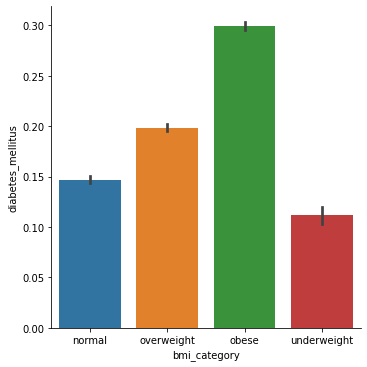

In [27]:
sns.catplot(x="bmi_category",y="diabetes_mellitus",kind="bar",data=training_set)

It is noteworthy that obese and overweight patients tend to have diabettes mellitus than other groups. We can encode BMI category according to ordinal encode.

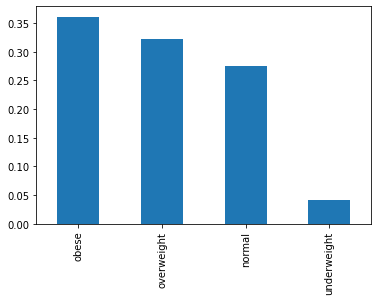

In [28]:
df_imp["bmi_category"].value_counts(normalize=True).plot(kind='bar')

In [29]:
df_imp["bmi_category"] = np.where(df_imp['bmi_category'] == 'obese', 3, df_imp['bmi_category'])
df_imp["bmi_category"] = np.where(df_imp['bmi_category'] == 'overweight', 2, df_imp['bmi_category'])
df_imp["bmi_category"] = np.where(df_imp['bmi_category'] == 'normal', 1, df_imp['bmi_category'])
df_imp["bmi_category"] = np.where(df_imp['bmi_category'] == 'underweight', 0, df_imp['bmi_category'])

In [30]:
df_imp.drop('bmi', axis = 1, inplace= True)

In [31]:
target = df_imp['diabetes_mellitus']
df_imp.drop('diabetes_mellitus', axis = 1, inplace = True)
df_imp['label'] = target 
training_set = df_imp[df_imp['label_train']==1]
testing_set = df_imp[df_imp['label_train']==0]
training_set = training_set.drop('label_train', axis = 1)
testing_set = testing_set.drop('label_train', axis = 1)

In [32]:
testing_set.drop('label', axis = 1, inplace= True)
print(training_set.head())
print(testing_set.head())

    age  elective_surgery  height  ...  icu_type_SICU  bmi_category  label
0  68.0                 0   180.3  ...              0             1    1.0
1  77.0                 0   160.0  ...              0             2    1.0
2  25.0                 0   172.7  ...              0             3    0.0
3  81.0                 1   165.1  ...              0             1    0.0
4  67.0                 0   190.5  ...              0             2    1.0

[5 rows x 172 columns]
         age  elective_surgery  ...  icu_type_SICU  bmi_category
128657  72.0                 0  ...              0             2
128658  86.0                 0  ...              0             2
128659  72.0                 0  ...              0             2
128660  66.0                 0  ...              0             2
128661  89.0                 0  ...              0             2

[5 rows x 171 columns]


In [33]:
training_set.to_csv('/content/gdrive/My Drive/WIDS/cleaned_data_train_final.csv')
testing_set.to_csv('/content/gdrive/My Drive/WIDS/cleaned_data_test_final.csv')

# Building model

As mentioned above, the dataset is imbalanced, therefore, it'd better to resample it before training any model.

In [34]:
dictionary = pd.read_excel('/content/gdrive/My Drive/WIDS/DataDictionaryWiDS2021-fixed-thu-tu.xlsx')

In [35]:
dictionary.head()

,class,feature,value,type,description,example,rank
0,APACHE covariate,glucose_apache,mmol/L,numeric,The glucose concentration measured during the ...,5,1
1,labs,h1_glucose_max,mmol/L,numeric,The highest glucose concentration of the patie...,5,2
2,labs,h1_glucose_min,mmol/L,numeric,The lowest glucose concentration of the patien...,5,2
3,labs,d1_glucose_max,mmol/L,numeric,The highest glucose concentration of the patie...,5,3
4,labs,d1_glucose_min,mmol/L,numeric,The lowest glucose concentration of the patien...,5,3


This is the suggestion from Mr. A, a PhD candidate in Medicine, who are doing research at a University in Australia.

Together with these valuable ranking, we also apply some feature selection algorithm to see whether two results coming from different perspectives are consitent or not.

# Feature selection under data science perspective

In [38]:
# load training set, which is used for both training and evaluating
df = pd.read_csv('/content/gdrive/My Drive/WIDS/cleaned_data_train_final.csv')

In [45]:
# before applying some classification feature selection, we should resample data to make sure that the number of patient with and without
#diabettes mellitus is not significantly imbalanced. The skewed data set would result in serious bias 
X = df.iloc[:, : -1]
y = df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.250, random_state=1, stratify=y)
print(Counter(y))
over = RandomOverSampler(sampling_strategy=0.4)
X_com, y_com = over.fit_resample(X_train, y_train)
print(Counter(y_com))
under = RandomUnderSampler(sampling_strategy=0.7)
X_com, y_com = under.fit_resample(X_com, y_com)
print(Counter(y_com))
X_com = pd.DataFrame(X_com)
X_com.columns = X.columns
X_com.drop('Unnamed: 0', axis = 1, inplace = True)

Counter({0.0: 100699, 1.0: 27958})
Counter({0.0: 75524, 1.0: 30209})
Counter({0.0: 43155, 1.0: 30209})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Now we have a better data set.

## Random Forest in Feature selection

In [46]:
rfc = RandomForestClassifier(n_jobs = -1, random_state= 0)
rfc.fit(X_com, y_com)
fet_indrfc = np.argsort(rfc.feature_importances_)[::-1]
fet_imp = rfc.feature_importances_[fet_indrfc]

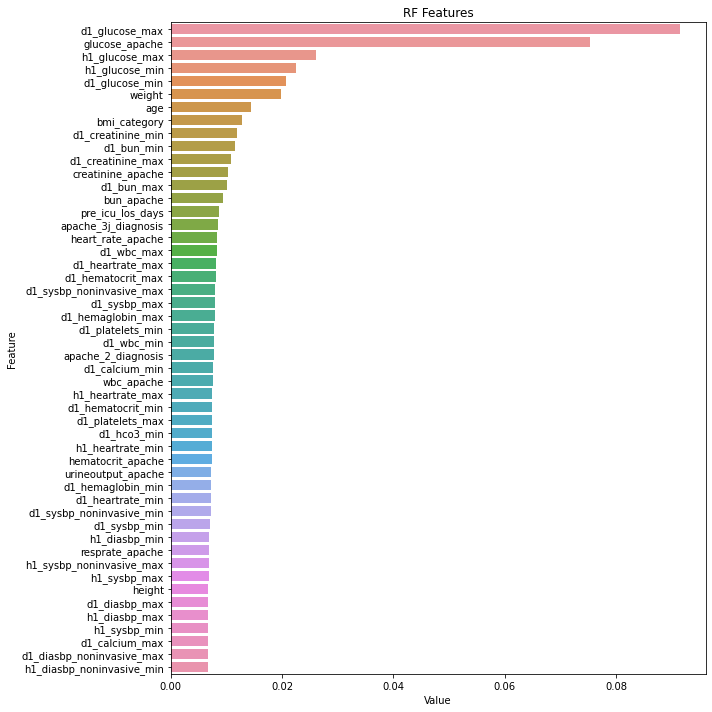

In [47]:
feature_imp = pd.DataFrame(sorted(zip(rfc.feature_importances_,X_com.columns)), columns=['Value','Feature'])
fea_rf = feature_imp.sort_values(by="Value", ascending=False)
fea_rf = fea_rf.iloc[0:50, :]
plt.figure(figsize=(10, 10))
sns.barplot(x="Value", y="Feature", data=fea_rf)
plt.title('RF Features')
plt.tight_layout()
plt.show()

At first glance, the set important features identified by feature selection algorithms is very similar to the list suggested by expert.


Let's take a look at other methods

## Lasso in Feature Selections

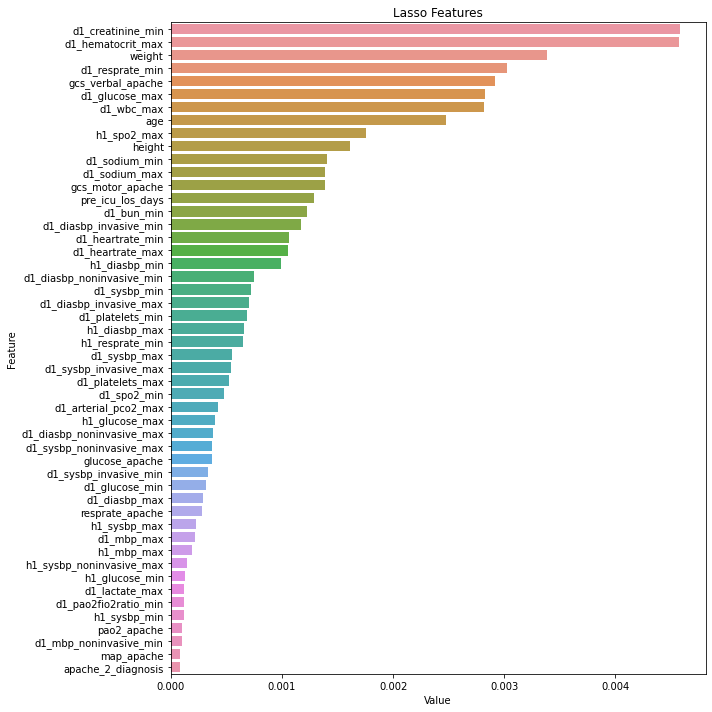

In [48]:
from sklearn.linear_model import LassoCV
lasso = LassoCV().fit(X_com.values, y_com)
importance = np.abs(lasso.coef_)
feature_names = np.array(X_train.columns)

fet_indrf2 = np.argsort(importance)[::-1]
feature_imp = pd.DataFrame(columns=['Value','Feature'])
feature_imp.loc[:,'Value'] = importance
feature_imp.loc[:,'Feature'] = X_com.columns

feature_imp = pd.DataFrame(sorted(zip(importance, X_com.columns)), columns=['Value','Feature'])
fea_lasso = feature_imp.sort_values(by="Value", ascending=False)
fea_lasso = fea_lasso.iloc[0:50, :]
plt.figure(figsize=(10, 10))
sns.barplot(x="Value", y="Feature", data=fea_lasso)
plt.title('Lasso Features')
plt.tight_layout()

In [69]:
def feature_imp(df_com, target):
    from sklearn.tree import ExtraTreeRegressor
    from collections import Counter
    # Build a forest and compute the feature importances
    forest = ExtraTreeRegressor(splitter='best', max_leaf_nodes=500)

    forest.fit(df_com, target)
    importances = forest.feature_importances_
    # std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    return indices

In [73]:
fea_imp_extratree = feature_imp(X_com, y_com)
fea_extraregress = X_com[X_com.columns[fea_imp_extratree[0:50]]].columns
print(fea_extraregress)

Index(['d1_glucose_max', 'bmi_category', 'age', 'd1_glucose_min', 'weight',
       'd1_creatinine_max', 'glucose_apache', 'd1_bun_min', 'gcs_motor_apache',
       'apache_3j_diagnosis', 'd1_calcium_min', 'd1_lactate_max',
       'd1_hemaglobin_max', 'heart_rate_apache', 'arf_apache',
       'd1_creatinine_min', 'd1_platelets_min', 'ventilated_apache',
       'apache_2_diagnosis', 'd1_wbc_max', 'd1_hematocrit_max',
       'd1_heartrate_max', 'creatinine_apache', 'pre_icu_los_days',
       'd1_sysbp_min', 'd1_hco3_max', 'd1_platelets_max',
       'd1_pao2fio2ratio_max', 'gcs_eyes_apache', 'd1_arterial_po2_max',
       'd1_sysbp_noninvasive_max', 'd1_sysbp_invasive_min', 'h1_glucose_max',
       'd1_arterial_pco2_max', 'height', 'map_apache', 'h1_temp_max',
       'h1_glucose_min', 'd1_sodium_max', 'd1_potassium_min',
       'd1_heartrate_min', 'h1_hematocrit_min', 'd1_resprate_max',
       'd1_bun_max', 'wbc_apache', 'd1_temp_min', 'h1_diasbp_min',
       'd1_mbp_invasive_max', 'd1_diasb

Our strategy:

If important feature from expert's point of view is in top 10 important feature identified by either algorithms above, we will consider it in our model.

In [80]:
top_10_rfc = list(fea_rf.iloc[:20, 1])
print(top_10_rfc)
top_10_ls = list(fea_lasso.iloc[:20,1])
print(top_10_ls)
top_10_extratree = list(fea_extraregress[:20])
print(top_10_extratree)

['d1_glucose_max', 'glucose_apache', 'h1_glucose_max', 'h1_glucose_min', 'd1_glucose_min', 'weight', 'age', 'bmi_category', 'd1_creatinine_min', 'd1_bun_min', 'd1_creatinine_max', 'creatinine_apache', 'd1_bun_max', 'bun_apache', 'pre_icu_los_days', 'apache_3j_diagnosis', 'heart_rate_apache', 'd1_wbc_max', 'd1_heartrate_max', 'd1_hematocrit_max']
['d1_creatinine_min', 'd1_hematocrit_max', 'weight', 'd1_resprate_min', 'gcs_verbal_apache', 'd1_glucose_max', 'd1_wbc_max', 'age', 'h1_spo2_max', 'height', 'd1_sodium_min', 'd1_sodium_max', 'gcs_motor_apache', 'pre_icu_los_days', 'd1_bun_min', 'd1_diasbp_invasive_min', 'd1_heartrate_min', 'd1_heartrate_max', 'h1_diasbp_min', 'd1_diasbp_noninvasive_min']
['d1_glucose_max', 'bmi_category', 'age', 'd1_glucose_min', 'weight', 'd1_creatinine_max', 'glucose_apache', 'd1_bun_min', 'gcs_motor_apache', 'apache_3j_diagnosis', 'd1_calcium_min', 'd1_lactate_max', 'd1_hemaglobin_max', 'heart_rate_apache', 'arf_apache', 'd1_creatinine_min', 'd1_platelets_mi

In [81]:
# combine all feature set
all_feat_2 = np.concatenate((top_10_rfc, top_10_ls), axis = 0)
all_feat_3 = np.concatenate((all_feat_2, top_10_extratree), axis = 0)
fet_ds = np.unique(all_feat_3, return_index=False)
print(fet_ds)

['age' 'apache_2_diagnosis' 'apache_3j_diagnosis' 'arf_apache'
 'bmi_category' 'bun_apache' 'creatinine_apache' 'd1_bun_max' 'd1_bun_min'
 'd1_calcium_min' 'd1_creatinine_max' 'd1_creatinine_min'
 'd1_diasbp_invasive_min' 'd1_diasbp_noninvasive_min' 'd1_glucose_max'
 'd1_glucose_min' 'd1_heartrate_max' 'd1_heartrate_min'
 'd1_hemaglobin_max' 'd1_hematocrit_max' 'd1_lactate_max'
 'd1_platelets_min' 'd1_resprate_min' 'd1_sodium_max' 'd1_sodium_min'
 'd1_wbc_max' 'gcs_motor_apache' 'gcs_verbal_apache' 'glucose_apache'
 'h1_diasbp_min' 'h1_glucose_max' 'h1_glucose_min' 'h1_spo2_max'
 'heart_rate_apache' 'height' 'pre_icu_los_days' 'ventilated_apache'
 'weight']


In [82]:
def showSameDiff(arr1, arr2):
  same = []
  diff1 = []
  diff2 = []
  for item in arr1:
    if item in arr2:
      same.append(item)
    else: diff1.append(item)
  for item in arr2:
    if item not in same:
      diff2.append(item)
  return same

In [99]:
# Feature selection by experts
feat_expert = list(dictionary['feature'])
final_fea = showSameDiff(feat_expert, fet_ds)
final_fea.append('bmi_category')
final_fea.remove('height')
final_fea.remove('weight')
final_fea

['glucose_apache',
 'h1_glucose_max',
 'h1_glucose_min',
 'd1_glucose_max',
 'd1_glucose_min',
 'd1_diasbp_invasive_min',
 'd1_diasbp_noninvasive_min',
 'heart_rate_apache',
 'd1_heartrate_max',
 'd1_heartrate_min',
 'h1_diasbp_min',
 'd1_lactate_max',
 'bmi_category']

In [100]:
final_fea.append('label')
final_fea

['glucose_apache',
 'h1_glucose_max',
 'h1_glucose_min',
 'd1_glucose_max',
 'd1_glucose_min',
 'd1_diasbp_invasive_min',
 'd1_diasbp_noninvasive_min',
 'heart_rate_apache',
 'd1_heartrate_max',
 'd1_heartrate_min',
 'h1_diasbp_min',
 'd1_lactate_max',
 'bmi_category',
 'label']

In [101]:
df_selected = df[final_fea]
df_selected.corr()

,glucose_apache,h1_glucose_max,h1_glucose_min,d1_glucose_max,d1_glucose_min,d1_diasbp_invasive_min,d1_diasbp_noninvasive_min,heart_rate_apache,d1_heartrate_max,d1_heartrate_min,h1_diasbp_min,d1_lactate_max,bmi_category,label
glucose_apache,1.000000,0.635587,0.627793,0.907008,0.461861,-0.019141,-0.025523,0.098187,0.094909,0.080959,-0.014339,0.110790,0.092317,0.344410
h1_glucose_max,0.635587,1.000000,0.963194,0.650776,0.242588,0.007580,-0.004295,0.069945,0.070307,0.065992,0.013476,0.069269,0.041663,0.227925
h1_glucose_min,0.627793,0.963194,1.000000,0.624012,0.278789,0.017831,0.000092,0.068228,0.068747,0.065748,0.021383,0.051224,0.046356,0.218919
d1_glucose_max,0.907008,0.650776,0.624012,1.000000,0.382449,-0.040517,-0.048898,0.103162,0.106434,0.089948,-0.039224,0.134608,0.091438,0.395412
d1_glucose_min,0.461861,0.242588,0.278789,0.382449,1.000000,0.036297,0.026340,0.057232,0.053035,0.049579,0.028991,-0.000826,0.123838,0.133580
d1_diasbp_invasive_min,-0.019141,0.007580,0.017831,-0.040517,0.036297,1.000000,0.253817,0.003280,-0.033159,0.075290,0.245259,-0.105059,0.034628,-0.038299
d1_diasbp_noninvasive_min,-0.025523,-0.004295,0.000092,-0.048898,0.026340,0.253817,1.000000,0.003320,-0.088462,0.131306,0.599088,-0.102275,0.019582,-0.048321
heart_rate_apache,0.098187,0.069945,0.068228,0.103162,0.057232,0.003280,0.003320,1.000000,0.809193,0.570212,0.049489,0.072384,-0.042677,-0.017146
d1_heartrate_max,0.094909,0.070307,0.068747,0.106434,0.053035,-0.033159,-0.088462,0.809193,1.000000,0.474266,0.000205,0.104208,-0.049876,-0.024822
d1_heartrate_min,0.080959,0.065992,0.065748,0.089948,0.049579,0.075290,0.131306,0.570212,0.474266,1.000000,0.073082,-0.025068,-0.000427,0.017786


After carefull consideration, we choose the features that have large correlation with "label", but not having high correlation with other

In [102]:
top = ['d1_glucose_max', 'h1_glucose_max', 'bmi_category', 'd1_glucose_min', 'age', 
        'd1_diasbp_invasive_min','d1_diasbp_noninvasive_min','heart_rate_apache',
        'd1_heartrate_max','h1_diasbp_min','d1_lactate_max']

X_selected = X[top]

In [ ]:
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=100) 
rf = RandomForestClassifier(n_estimators = 400, max_features = 8, min_samples_split = 20, min_samples_leaf = 10)
xgb = XGBClassifier(max_depth=8, n_estimators=20,  objective='multi:softprob', learning_rate=0.3, num_class=2)
svc = svm.SVC(probability=True)

round = 0
for train_index, test_index in skf.split(X_selected,y): 
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:] 
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    over = RandomOverSampler(sampling_strategy=0.4)
    X_over, y_over = over.fit_resample(X_train, y_train)
    under = RandomUnderSampler(sampling_strategy=0.6)
    X_under, y_under = under.fit_resample(X_over, y_over)
    X_under = pd.DataFrame(X_under)
    X_under.columns = X_train.columns 
    
    models = list()
    # create a pipeline
    models.append(('rf', rf))
    models.append(('xgb', xgb))
    models.append(('svc', svc))

    model = VotingClassifier(estimators=models, voting='soft', weights=[3,4,3])
    
    model.fit(X_under.values, y_under)

    round +=1

    print(f"FOLD = {round}")
    print(accuracy_score(y_under, model.predict(X_under.values)))
    print(accuracy_score(y_test, model.predict(X_test.values)))

    print(classification_report(y_under, model.predict(X_under.values)))
    print(classification_report(y_test, model.predict(X_test.values)))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
